In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator
import pickle

In [12]:
class dNdEInterpolator(object):
    def __init__(self):
        data = np.loadtxt("gammamc_dif.dat")
        EdNdE = data.reshape((12, 24, 250))  # N_channels, N_masses, N_x
        m_GeV = np.array([2.0, 4.0, 6.0, 8.0, 10.0,
                          25.0, 50.0, 80.3, 91.2, 100.0,
                          150.0, 176.0, 200.0, 250.0, 350.0, 500.0, 750.0,
                          1000.0, 1500.0, 2000.0, 3000.0, 5000.0, 7000.0, 1E4])
        # Channel to index
        channel_to_idx = {'cc': 0, 'bb': 1, 'tt': 2, 'tautau': 3, 'ww': 4, 'zz': 5, 'mumu': 6,
                          'gg': 7, 'ee': 8, 'ss': 9, 'uu': 10, 'dd': 11}
        # x = log10(E/M_chi)
        ndec = 10.0
        xedge = np.linspace(0, 1.0, 251)
        x = 0.5 * (xedge[1:] + xedge[:-1]) * ndec - ndec

        ednde_interp = {chan: RegularGridInterpolator([m_GeV, x],
                                                      EdNdE[ichan, :, :],
                                                      bounds_error=False,
                                                      fill_value=None)
                       for chan, ichan in channel_to_idx.items()}
        self.m = m_GeV
        self.x = x
        self.EdNdE = ednde_interp
        self.channels = channel_to_idx
    def dNdE(self, chan, E, m):
        """ Energies should be always in GeV, then this will return
        dN/dE in units of GeV^-1.
        """
        x = np.log10(E/m)
        EdNdE = self.EdNdE[chan]((m, x))
        EdNdE[EdNdE < 0 ] = 0
        return EdNdE/E

interp = dNdEInterpolator()

[  0.71203953   1.30163073   2.26197495   3.93086195   6.54891144
  11.28506606  18.9472716   29.81863724  54.0137222   94.66057036
 191.24150428 547.16201012]


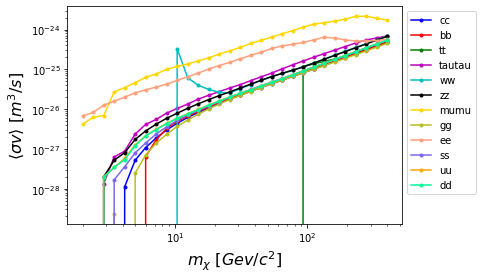

In [15]:
from scipy.integrate import quad

Edges = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
 5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
 3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
 1.00000000e+06]) #MeV

Mass = np.geomspace(2,400,30) #GeV


file = open('F_ann_val.pckl', 'rb')
F_val = pickle.load(file)
file.close()

cfac = 1.81493167e39

F_comb = cfac*F_val[1]
cov_Fcomb = cfac**2*F_val[3]
inv_covFcomb = np.linalg.inv(cov_Fcomb)


def get_weightedE(Edges):
    WeightedEmean = np.zeros((12))
    for i,j in enumerate(zip(Edges[:-1],Edges[1:])):
        norm, err = quad(lambda E: 1/(E**2), j[0], j[1])
        weighted, w_err = quad(lambda E: 1/E, j[0], j[1])   # E/E**2
        WeightedEmean[i] = weighted/norm
    print(WeightedEmean)
    return WeightedEmean


def get_sigmav(mass,Energy,chan, F, icovF):
    
    q = np.zeros((mass.shape[0],Energy.shape[0]))
    sigmav = np.zeros((mass.shape[0]))

    for imass, m in enumerate(mass):
        q[imass] = interp.dNdE(chan,Energy,m)/(m**2)
        if np.any(q[imass]):
            sigmav[imass] = np.dot(q[imass] , np.dot(icovF,F)) / np.dot(q[imass] , np.dot(icovF, q[imass]))
        else:
            sigmav[imass] = 0
            
    return sigmav


Energy = get_weightedE(Edges*10**(-3))  # E should be in GeV now

colors = ['b','r','g','m', 'c','k','gold','tab:olive', 'lightsalmon','mediumslateblue','orange','mediumspringgreen']

for ichan, chan in enumerate(interp.channels.keys()):
    Q = get_sigmav(Mass, Energy, chan ,F_comb, inv_covFcomb)

    plt.plot(Mass, Q, '.-',color = colors[ichan], label = f'{chan}')

plt.xscale('log')
plt.xlabel(r'$m_{\chi}\,\,[Gev/c^{2}]$', fontsize = 16)
plt.ylabel(r'$\langle\sigma v \rangle \,\,[m^{3}/s]$', fontsize = 16)
plt.yscale('log')
plt.legend(bbox_to_anchor = (1,1))
plt.savefig('sigv.jpg', bbox_inches= 'tight', dpi= 300)

In [4]:
Edges*10**-3

array([5.24807460e-01, 1.00000000e+00, 1.73780083e+00, 3.01995172e+00,
       5.24807460e+00, 8.31763771e+00, 1.58489319e+01, 2.29086765e+01,
       3.98107171e+01, 7.58577575e+01, 1.20226443e+02, 3.31131121e+02,
       1.00000000e+03])

In [5]:
Edges = np.array([5.24807460e+02, 1.00000000e+03, 1.73780083e+03, 3.01995172e+03,
 5.24807460e+03, 8.31763771e+03, 1.58489319e+04, 2.29086765e+04,
 3.98107171e+04, 7.58577575e+04, 1.20226443e+05, 3.31131121e+05,
 1.00000000e+06])